# Modeling and Simulation in Python

Chapter 24

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Rolling paper

We'll start by loading the units we need.

In [2]:
radian = UNITS.radian
m = UNITS.meter
s = UNITS.second

<Unit('second')>

And creating a `Params` object with the system parameters

In [3]:
params = Params(Rmin = 0.02 * m,
                Rmax = 0.055 * m,
                L = 47 * m,
                t_end = 130 * s)

,values
Rmin,0.02 meter
Rmax,0.055 meter
L,47 meter
t_end,130 second


The following function estimates the parameter `k`, which is the increase in the radius of the roll for each radian of rotation. 

In [4]:
def estimate_k(params):
    """Estimates the parameter `k`.
    
    params: Params with Rmin, Rmax, and L
    
    returns: k in meters per radian
    """
    unpack(params)
    
    Ravg = (Rmax + Rmin) / 2
    Cavg = 2 * pi * Ravg
    revs = L / Cavg
    rads = 2 * pi * revs
    k = (Rmax - Rmin) / rads
    return k

As usual, `make_system` takes a `Params` object and returns a `System` object.

In [5]:
def make_system(params):
    """Make a system object.
    
    params: Params with Rmin, Rmax, and L
    
    returns: System with init, k, and ts
    """
    unpack(params)
    
    init = State(theta = 0 * radian,
                 y = 0 * m,
                 r = Rmin)
    
    k = estimate_k(params)
    
    return System(init=init, k=k, t_end=t_end)

Testing `make_system`

In [6]:
system = make_system(params)

,values
init,theta 0 radian y 0 meter r ...
k,2.7925531914893616e-05 meter
t_end,130 second


In [7]:
system.init

,values
theta,0 radian
y,0 meter
r,0.02 meter


Now we can write a slope function based on the differential equations

$\omega = \frac{d\theta}{dt} = 10$

$\frac{dy}{dt} = r \frac{d\theta}{dt}$

$\frac{dr}{dt} = k \frac{d\theta}{dt}$


In [8]:
def slope_func(state, t, system):
    """Computes the derivatives of the state variables.
    
    state: State object with theta, y, r
    t: time
    system: System object with r, k
    
    returns: sequence of derivatives
    """
    theta, y, r = state
    unpack(system)
    
    omega = 10 * radian / s
    dydt = r * omega
    drdt = k * omega
    
    return omega, dydt, drdt

Testing `slope_func`

In [9]:
slope_func(system.init, 0*s, system)

(<Quantity(10.0, 'radian / second')>,
 <Quantity(0.2, 'meter * radian / second')>,
 <Quantity(0.0002792553191489362, 'meter * radian / second')>)

We'll use an event function to stop when `y=L`.

In [10]:
def event_func(state, t, system):
    """Detects when we've rolled length `L`.
    
    state: State object with theta, y, r
    t: time
    system: System object with r, k
    
    returns: difference between `y` and `L`
    """
    theta, y, r = state
    unpack(system)
    
    return y - L

Now we can run the simulation.

In [11]:
results, details = run_ode_solver(system, slope_func, events=event_func)
details

,values
sol,None
t_events,[[125.33333333333333]]
nfev,50
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


And look at the results.

In [12]:
results.tail()

,theta,y,r
0.105788,1.057884,0.021173,0.020030
1.057979,10.579789,0.213159,0.020295
10.579884,105.798842,2.272268,0.022954
105.798938,1057.989376,36.788891,0.049545
125.333333,1253.333333,47.000000,0.055000


The final value of `y` is 47 meters, as expected.

In [13]:
unrolled = get_last_value(results.y) * m

<Quantity(47.0, 'meter')>

The final value of radius is `R_max`.

In [14]:
radius = get_last_value(results.r) * m

<Quantity(0.05500000000000001, 'meter')>

The total number of rotations is close to 200, which seems credible.

In [15]:
rotation = get_last_value(results.theta) / 2 / np.pi

199.47419534184215

The elapsed time is plausible.

In [16]:
t_final = get_last_label(results) * s

<Quantity(125.33333333333333, 'second')>

### Plotting

Before I plot the results, I'll run the simulation again to get equally-spaced points

In [17]:
t_final = get_last_label(results)
ts = linspace(0, t_final, 101)
results, details = run_ode_solver(system, slope_func, t_eval=ts)
details

,values
sol,None
t_events,[]
nfev,50
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


Plotting `theta`

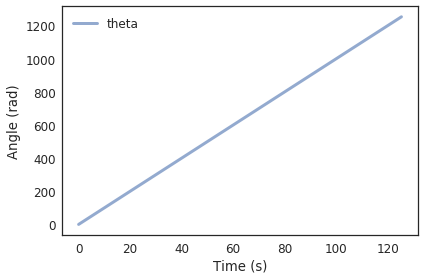

In [18]:
def plot_theta(results):
    plot(results.theta, color='C0', label='theta')
    decorate(xlabel='Time (s)',
             ylabel='Angle (rad)')
    
plot_theta(results)

Plotting `y`

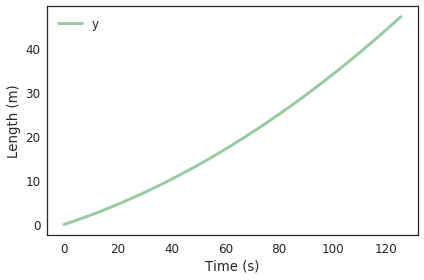

In [19]:
def plot_y(results):
    plot(results.y, color='C1', label='y')

    decorate(xlabel='Time (s)',
             ylabel='Length (m)')
    
plot_y(results)

Plotting `r`

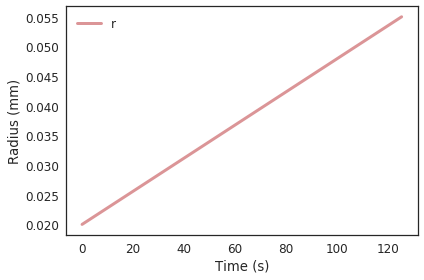

In [20]:
def plot_r(results):
    plot(results.r, color='C2', label='r')

    decorate(xlabel='Time (s)',
             ylabel='Radius (mm)')
    
plot_r(results)

We can also see the relationship between `y` and `r`, which I derive analytically in the book.

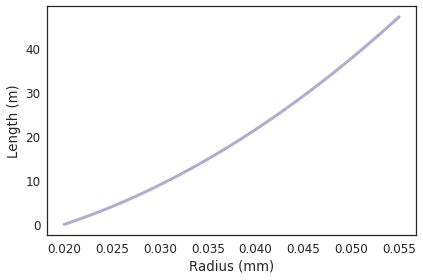

In [21]:
plot(results.r, results.y, color='C3')

decorate(xlabel='Radius (mm)',
         ylabel='Length (m)',
         legend=False)

And here's the figure from the book.

Saving figure to file figs/chap11-fig01.pdf


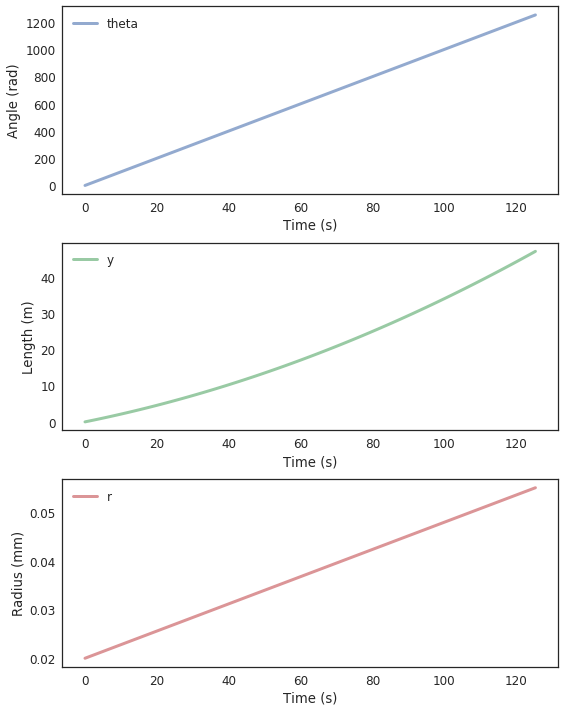

In [22]:
subplot(3, 1, 1)
plot_theta(results)

subplot(3, 1, 2)
plot_y(results)

subplot(3, 1, 3)
plot_r(results)

savefig('figs/chap11-fig01.pdf')

### Exercises

**Exercise:**